## Machine Learning Engineering Career Track Capstone
    
### Step 6: Experiment With Various Models

The purpose of this step is for you to rigorously test how to build the best model for analyzing the patterns found in your dataset. 
Perform some of the following activities:
- Build an automated process to test many modeling techniques and ML algorithms with your data to see which one yields the best results
- Define the performance metric(s) best applied to your problem (accuracy, F1, RSME, LOC, etc.)
- Test various loss functions across models to see which one yields the best result
- Perform tuning of one or more model, across one or multiple hyperparameters
- Build a robust cross-validation process for your problem
- Ensemble multiple models together, and demonstrate the superior results
- Analyze the prediction results to confirm how some of your models ended up properly generalizing or overfitting the data
- Present your best model(s)

In [2]:
import os
import pickle
import sys
from random import sample
from time import time
from tempfile import mkdtemp
from shutil import rmtree

from imblearn.over_sampling import SMOTE
from IPython.display import Audio, display
import librosa
from librosa.display import waveplot
import moviepy.editor as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, silhouette_score
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
train_df = pd.read_pickle('data/features/train/df.pkl')
dev_df = pd.read_pickle('data/features/dev/df.pkl')
test_df = pd.read_pickle('data/features/test/df.pkl')
train_df.extract_limit.head(1).values

array([110250])

In [4]:
train_df.dropna(inplace=True)
dev_df.dropna(inplace=True)
test_df.dropna(inplace=True)
train_df.shape, dev_df.shape, test_df.shape

((9983, 178), (1107, 176), (2610, 176))

In [5]:
y_train = train_df['emotion_class']
y_dev = dev_df['emotion_class']
y_test = test_df['emotion_class']
print(y_train.shape, y_dev.shape, y_test.shape)

(9983,) (1107,) (2610,)


In [6]:
def get_features(df: pd.DataFrame):
    return df[(c for c in df.columns.values if isinstance(c, int))]

def get_non_features(df: pd.DataFrame):
    return df[(c for c in df.columns.values if not isinstance(c, int))] 

In [7]:
X_train, X_dev, X_test = get_features(train_df), get_features(dev_df), get_features(test_df)
print(X_train.shape, X_dev.shape, X_test.shape)

(9983, 160) (1107, 160) (2610, 160)


# Experiment: Oversampling

As detailed in the previous notebook, there is class imbalance. Here I test various oversampling methods. Undersampling is not appropriate since we only have around 10K training examples.

In [16]:
# SMOTE generates synthetic samples

from imblearn.over_sampling import SMOTE
from collections import Counter

oversample = SMOTE(random_state=0, n_jobs=-1)
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(list(Counter(y_over).items()))
X_over.shape, y_over.shape

[(4.0, 4708), (6.0, 4708), (2.0, 4708), (5.0, 4708), (3.0, 4708), (1.0, 4708), (0.0, 4708)]


((32956, 160), (32956,))

Note that now we have 3x the training data.

In [17]:
def try_rf(X, y):
    model = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
    model.fit(X_over, y_over)
    y_pred = model.predict(X_dev)
    return f1_score(y_dev, y_pred, average='weighted')

In [18]:
try_rf(X_over, y_over)

0.28973100512071337

Looks like oversampling boosts F1 score by around 0.04 even when the classifier was supposedly taking class balance into account with class_weight='balanced'!

In [15]:
# ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, 
# and its greatest advantages are not copying the same minority data, and generating  
# more data for “harder to learn” examples.
from imblearn.over_sampling import ADASYN

X_over, y_over = ADASYN(random_state=0, n_jobs=-1).fit_resample(X_train, y_train)
print(X_over.shape, y_over.shape)
try_rf(X_over, y_over)

(32992, 160) (32992,)


0.28523092194778815

We can also try combination of over- and under-sampling methods

In [20]:
from imblearn.combine import SMOTETomek, SMOTEENN

X_over, y_over = SMOTETomek(random_state=0, n_jobs=-1).fit_resample(X_train, y_train)
print(X_over.shape, y_over.shape)
try_rf(X_over, y_over)

(32848, 160) (32848,)


0.293537673904781

In [21]:
X_over, y_over = SMOTEENN(random_state=0, n_jobs=-1).fit_resample(X_train, y_train)
print(X_over.shape, y_over.shape)
try_rf(X_over, y_over)

(25196, 160) (25196,)


0.10161598163757142

Looks like overall SMOTE Tomek wins!

## Experiment: Selecting Standardization

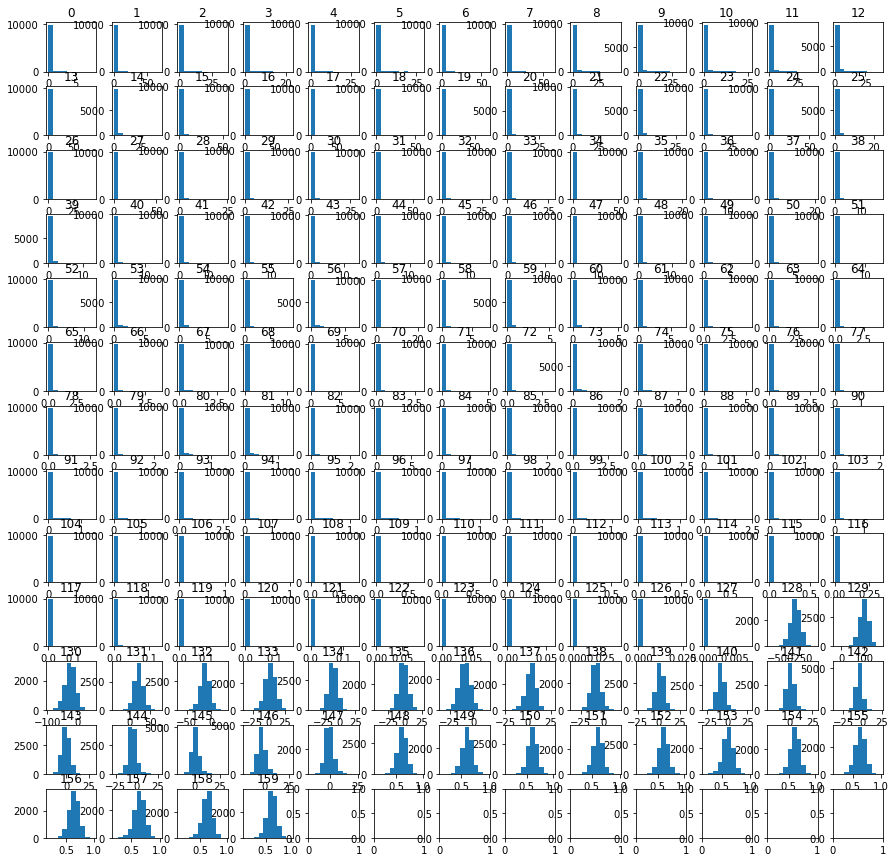

In [50]:
sqrt = 13
fig, axes = plt.subplots(nrows=sqrt, ncols=sqrt, figsize=(15,15))
i, j = 0, 0
for feat in range(0, 160, 1):
    train_df[[feat]].hist(figsize=(3,3), ax=axes[i, j], legend=None, grid=False)
    j += 1
    if j == sqrt:
        i += 1
        j = 0

Looking at the features generated, most follow a power-law distribution that is right-skewed, 1 appears bimodal, 20 or so are definitely Gaussian. 

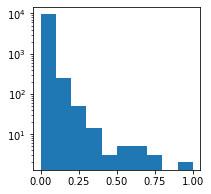

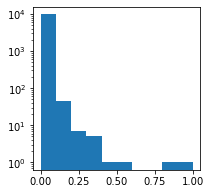

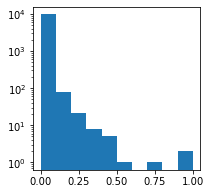

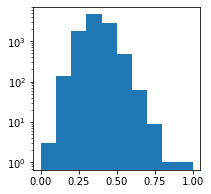

In [52]:
for i in range(80, 160, 20):
    scaled = MinMaxScaler().fit_transform(train_df[[i]].values)
    plt.figure(figsize=(3, 3))
    plt.yscale('log')
    plt.hist(scaled)

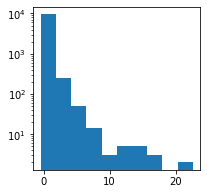

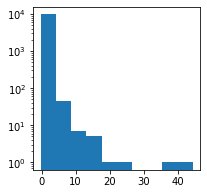

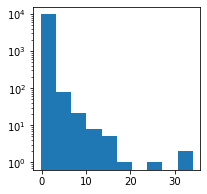

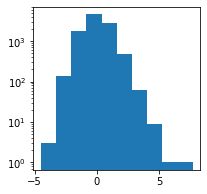

In [53]:
for i in range(80, 160, 20):
    scaled = StandardScaler().fit_transform(train_df[[i]].values)
    plt.figure(figsize=(3, 3))
    plt.yscale('log')
    plt.hist(scaled)

Looking at the features generated, most follow a power-law distribution, some follow a skewed normal distribution, 1 appears bimodal, 20 or so are definitely Gaussian. This suggest to me that standardization should be OK, but we can try both.

In the last notebook I determined a good audio limit, extracted features based on that limit, and checkpointed the results. Here I continue to experiment with the next stages the ML pipeline.

In [55]:
def print_f1_weighted(pipe):
    train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
    devel_score = f1_score(y_dev, pipe.predict(X_dev), average='weighted')
    print('Train score: ', train_score)
    print('Devel score: ', devel_score)

In [56]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X_over, y_over)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=0))])

In [57]:
def print_f1_weighted(pipe):
    train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
    devel_score = f1_score(y_dev, pipe.predict(X_dev), average='weighted')
    print('Train score: ', train_score)
    print('Devel score: ', devel_score)

In [58]:
print_f1_weighted(pipe)

Train score:  0.32003613391372937
Devel score:  0.09591415215376839


In [59]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

pipe.fit(X_over, y_over)

print_f1_weighted(pipe)

Train score:  0.32106962829883584
Devel score:  0.11130789804477417


Looks like StandardScaler yields slightly better performance.

## Experiment: PCA components

In [230]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=0)),
    ('estimator', RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1))
])

parameters = {
    'pca__n_components': list(range(1, 10)) + list(range(10, 161, 10)),  # total of 160 features
}

search = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)
search.fit(X_train, y_train)
search.score(X_dev, y_dev)

0.27673701466165024

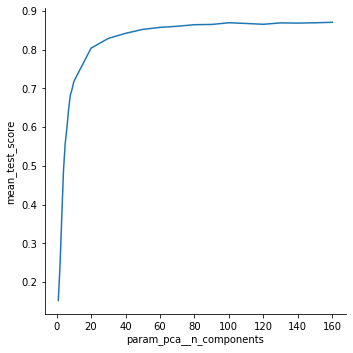

In [231]:
result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
sns.relplot(data=result_df, kind='line',
            x='param_pca__n_components',
            y='mean_test_score')
_= plt.show()

In [238]:
for param, score in zip(search.cv_results_['params'], search.cv_results_['mean_test_score']):
    print(list(param.values())[0], score)


1 0.15241729822150557
2 0.24245686805755
3 0.3667641116195962
4 0.48727578957823114
5 0.5572446618386353
6 0.5981900888399778
7 0.647100279068655
8 0.682904302301409
9 0.6981330818664324
10 0.7174978069673863
20 0.8038701244642551
30 0.8288912071065605
40 0.8420801879457155
50 0.8522141469884692
60 0.8574013393543265
70 0.8603090892423039
80 0.8643766348995117
90 0.865013905301576
100 0.8694074363430767
110 0.8675928859774341
120 0.8654319100547502
130 0.8690286934954974
140 0.8685211861019402
150 0.8693102831836775
160 0.8705789031781197


Doesn't really get better after 80 components.

## Comparing Models

In [239]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=80, random_state=0)),
    ('estimator', GaussianNB())  # this is just a placeholder so I can search over estimators
])

In [240]:
classifiers = [
    GaussianNB(),
    DecisionTreeClassifier(random_state=0, class_weight='balanced'),
    RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'),
    KNeighborsClassifier(n_jobs=-1),
    LinearSVC(multi_class='ovr', class_weight='balanced', random_state=0),
    LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=0, max_iter=1000, 
                       n_jobs=-1),  
    LogisticRegression(multi_class='ovr', class_weight='balanced', random_state=0, max_iter=1000, n_jobs=-1),   
    MLPClassifier(random_state=0),
    RidgeClassifier(class_weight='balanced', random_state=0)
]

parameters = [{'estimator': [clf]} for clf in classifiers]
search = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1)

search.fit(X_train, y_train)

search.best_params_

{'estimator': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)}

In [241]:
tmp = zip([str(x['estimator']) for x in search.cv_results_['params']], search.cv_results_['mean_test_score'])
res_df = pd.DataFrame(tmp, columns=["Model", "F1-weighted train"])
res_df.sort_values('F1-weighted train', ascending=False)

,Model,F1-weighted train
2,RandomForestClassifier(class_weight='balanced'...,0.864691
3,KNeighborsClassifier(n_jobs=-1),0.724363
7,MLPClassifier(random_state=0),0.613828
1,DecisionTreeClassifier(class_weight='balanced'...,0.580205
5,"LogisticRegression(class_weight='balanced', ma...",0.223648
8,"RidgeClassifier(class_weight='balanced', rando...",0.219893
4,"LinearSVC(class_weight='balanced', random_stat...",0.219705
6,"LogisticRegression(class_weight='balanced', ma...",0.215513
0,GaussianNB(),0.114682


In [242]:
search.score(X_dev, y_dev)

0.28519597622070914

/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/home/bin/anaconda3/envs/good/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

Looks like the MLP, KNN, and RF classifiers had best performance without any hyperparameter optimization. The RF score on the dev set was ~0.285

### Optimizing MLPClassifier

In [204]:
base_mlp = MLPClassifier(random_state=0)
base_mlp.hidden_layer_sizes, clf.alpha, clf.learning_rate

((100,), 0.0001, 'constant')

Be sure to include the default values in the grid search

In [157]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', MLPClassifier(random_state=0, max_iter=2000))
])

parameters = {
    'estimator__hidden_layer_sizes': [100, 105, 110, 115, 120, 125, 130],
    'estimator__alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],  # L2 penalty (regularization term)
    'estimator__learning_rate': ['constant', 'invscaling', 'adaptive']
}

search_mlp = GridSearchCV(
    pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1
).fit(X_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


In [166]:
print('Train score: ', search_mlp.score(X_train, y_train))
print('Dev score: ', search_mlp.score(X_dev, y_dev))

Train score:  0.3060811545527449
Dev score:  0.2599004344917845


In [177]:
def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)

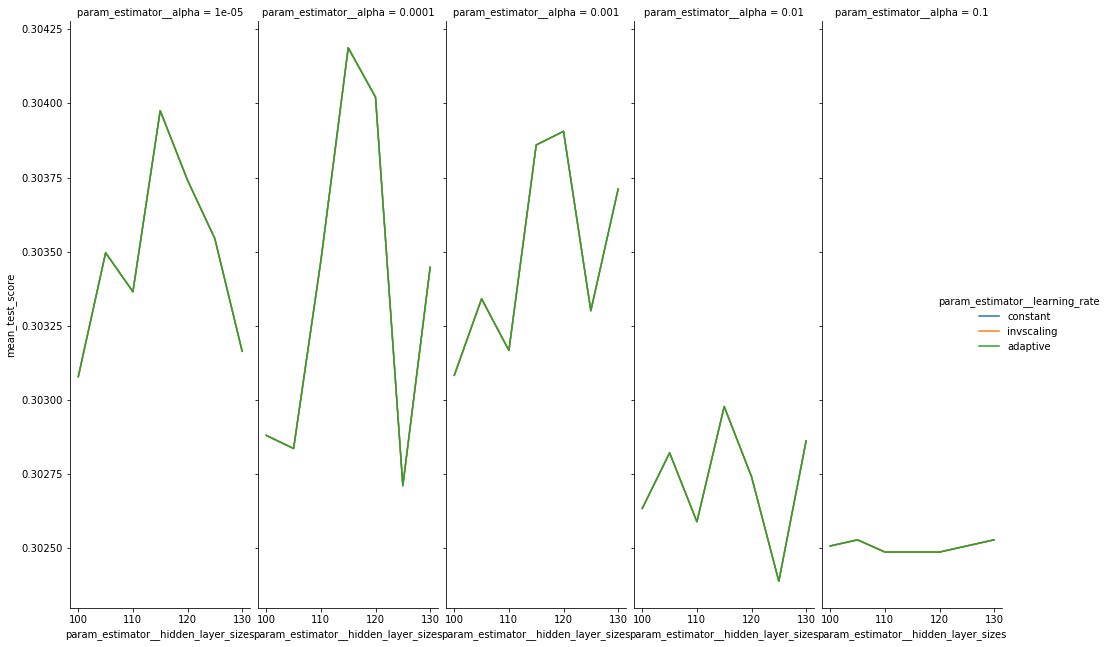

In [178]:
grid_search_plot(search_mlp, 
                 'estimator__hidden_layer_sizes', col='estimator__alpha', hue='estimator__learning_rate')

Learning rate does not have much effect, alpha is good around default value of 0.0001, and hidden units seems best around 115.

In [179]:
parameters = {
    'estimator__hidden_layer_sizes': list(range(110, 121)),
    'estimator__alpha': np.linspace(0.0001, 0.00001, 10),  # L2 penalty (regularization term)
}

search_mlp = GridSearchCV(
    pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1
).fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


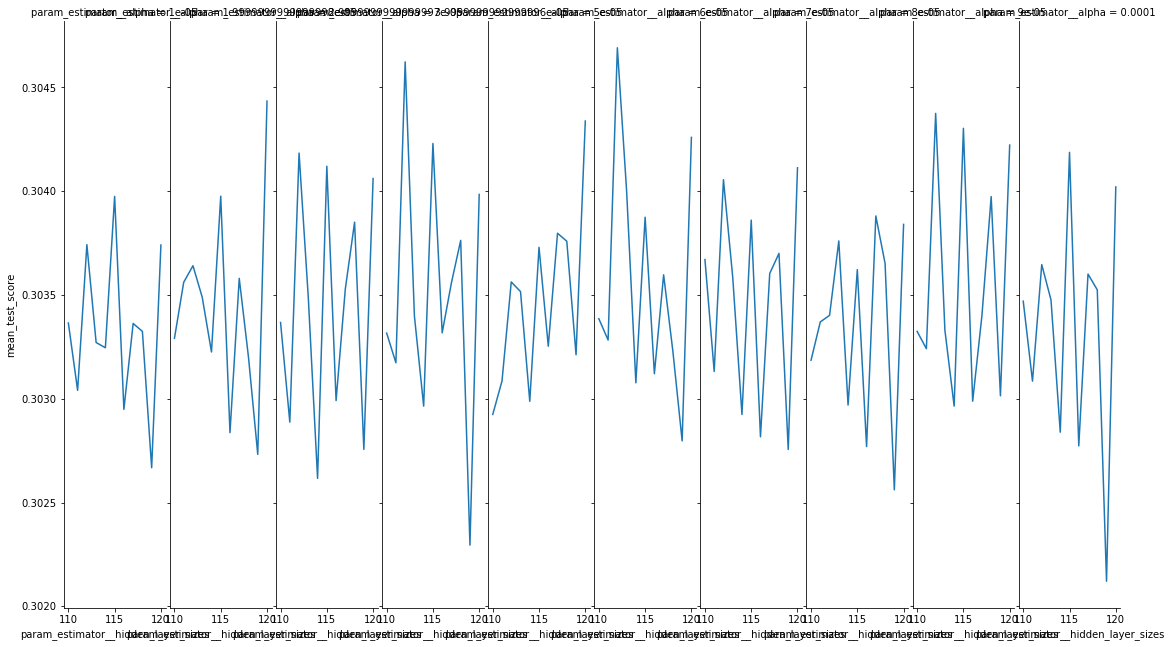

In [183]:
grid_search_plot(search_mlp, x='estimator__hidden_layer_sizes', col='estimator__alpha')

There doesn't appear to be a discernable pattern here, so I'll take the best estimator and compare it to baseline.

In [185]:
print(search_mlp.best_estimator_)
print(search_mlp.best_params_)
print('Train score: ', search_mlp.score(X_train, y_train))
print('Dev score: ', search_mlp.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 MLPClassifier(alpha=6e-05, hidden_layer_sizes=112,
                               max_iter=2000, random_state=0))])
{'estimator__alpha': 6e-05, 'estimator__hidden_layer_sizes': 112}
Train score:  0.3044336666871381
Dev score:  0.25736382777584715


The MLP baseline train score was 0.302902, so I've slightly improved that with the hyperparameter optimization.
The dev score baseline is as follows:

In [209]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', MLPClassifier(random_state=0, max_iter=2000))
])


pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2580852002445182

Performance on the dev set is slightly worse for the hyperparameter-optimized model than the default MLP model.

### Optimizing KNeighborsClassifier

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': list(range(1, 11)),
    'estimator__weights': ['uniform', 'distance'],
    # p = 1, equivalent to using manhattan_distance (l1), 
    # For arbitrary p, minkowski_distance (l_p) is used.
    'estimator__p': list(range(1, 11)),
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

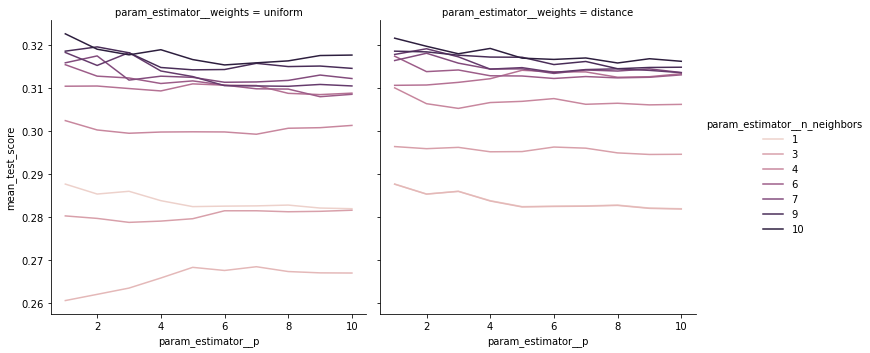

<Figure size 1280x960 with 0 Axes>

In [150]:
grid_search_plot(search_knn, hue='estimator__n_neighbors', x='estimator__p', col='estimator__weights')

Looks like increasing p slightly worsens results, so we can fix that to 1. N_neighbors definitely improves performance. 

In [151]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': list(range(11, 21)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__p': [1],
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

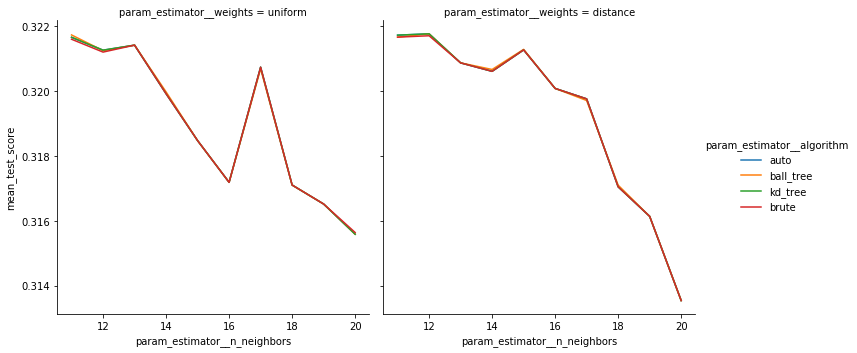

<Figure size 1280x960 with 0 Axes>

In [154]:
grid_search_plot(search_knn, x='estimator__n_neighbors', hue='estimator__algorithm', col='estimator__weights')

Looks like n_neighbors peaks around 11-12 and the algorithm has little effect.

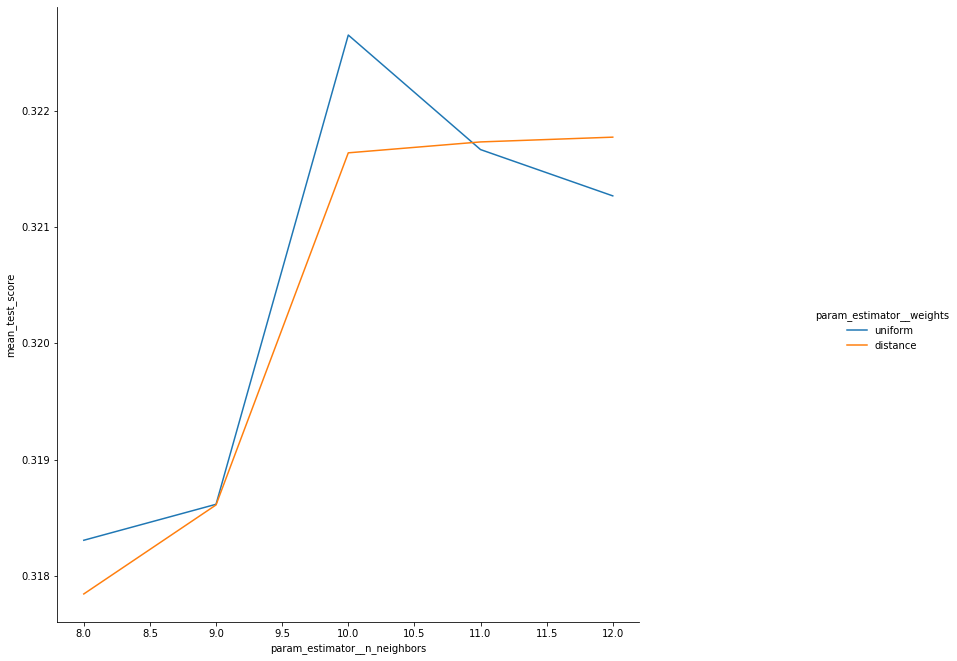

In [207]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

parameters = {
    'estimator__n_neighbors': [8, 9, 10, 11, 12],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1],
}

search_knn = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)
grid_search_plot(search_knn, x='estimator__n_neighbors', hue='estimator__weights')

Looks like the best hyperparams are p=1, weights=uniform, n_neighbors=10

In [208]:
print(search_knn.best_estimator_)
print(search_knn.best_params_)
print('Train score: ', search_knn.score(X_train, y_train))
print('Dev score: ', search_knn.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=10, p=1))])
{'estimator__n_neighbors': 10, 'estimator__p': 1, 'estimator__weights': 'uniform'}
Train score:  0.40890122166136206
Dev score:  0.2952544287092447


Comparison with unoptimized KNN clf...

In [210]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', KNeighborsClassifier(n_jobs=-1))
])

pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2863050675215029

I was able to improve the KNN classifier perf on the dev set using hyperparameter search. Also the KNN perf is superceding that of the MLP classifier.

### Optimizing RandomForestClassifier

Finally, here I will try optimizing RF which was number 1 in the initial naive assessment.

In [243]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'))
])

parameters = {
    'estimator__n_estimators': list(range(80, 121, 10)),
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_features': ['auto', 'sqrt', 'log2'],
}

search_rf = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

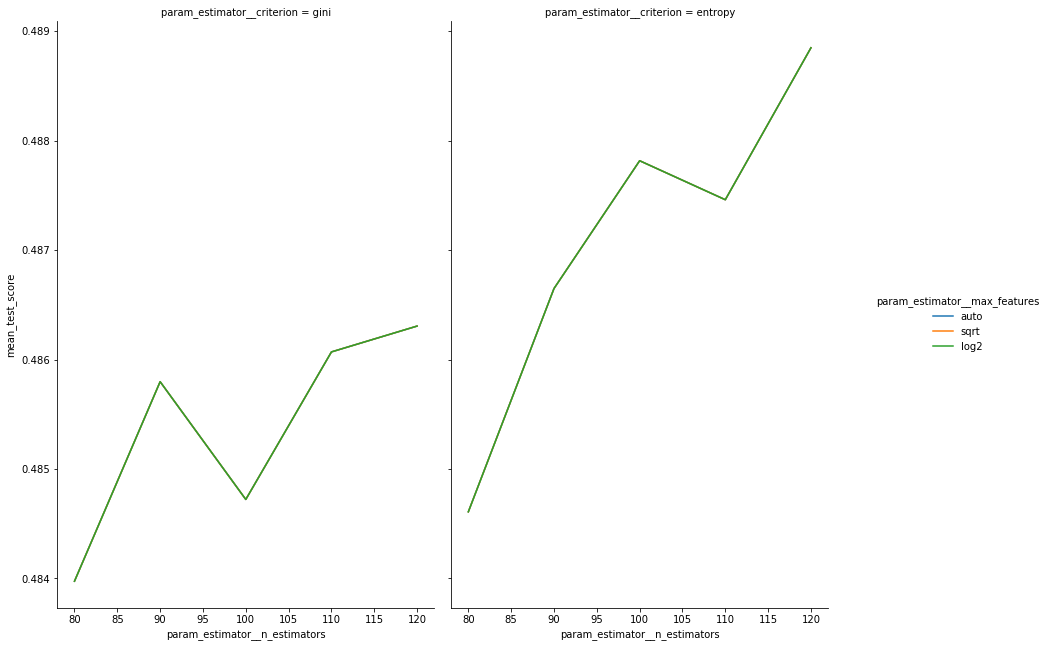

In [244]:
grid_search_plot(search_rf, x='estimator__n_estimators', hue='estimator__max_features', col='estimator__criterion')

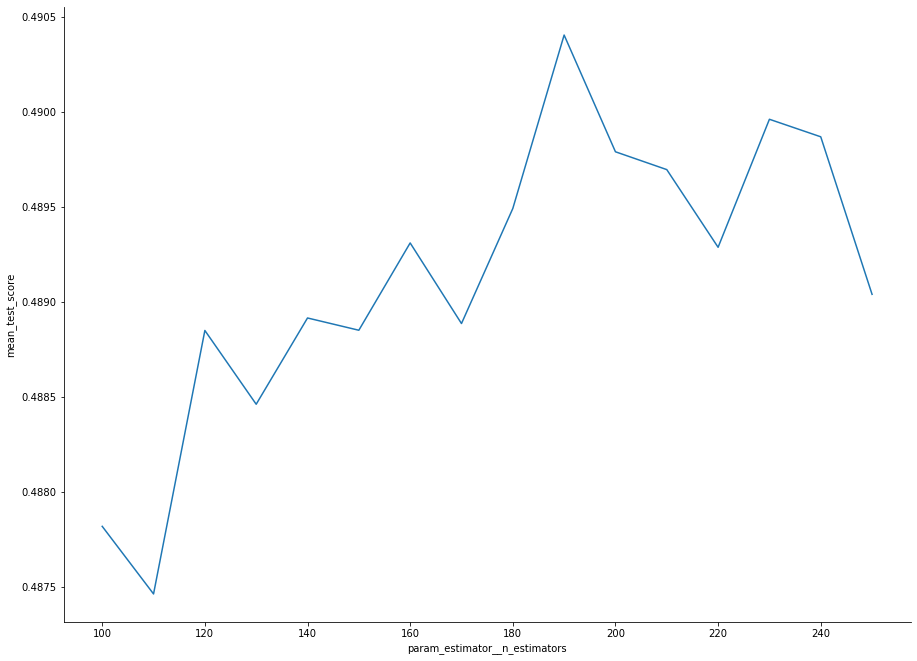

In [245]:
parameters = {
    'estimator__n_estimators': list(range(100, 251, 10)),
    'estimator__criterion': ['entropy'],
}

search_rf = GridSearchCV(pipe, parameters, scoring='f1_weighted', cv=5, n_jobs=-1).fit(X_train, y_train)

grid_search_plot(search_rf, x='estimator__n_estimators')

In [247]:
print(search_rf.best_estimator_)
print(search_rf.best_params_)
print('Train score: ', search_rf.score(X_train, y_train))
print('Dev score: ', search_rf.score(X_dev, y_dev))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=4, random_state=0)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', n_estimators=190,
                                        n_jobs=-1, random_state=0))])
{'estimator__criterion': 'entropy', 'estimator__n_estimators': 190}
Train score:  0.9994841445754338
Dev score:  0.19468963393307823


In [40]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=4, random_state=0)),
    ('estimator', RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced'))
])

pipe.fit(X_train, y_train)
f1_score(y_dev, pipe.predict(X_dev), average='weighted')

0.2714765081882874

In [41]:
f1_score(y_test, pipe.predict(X_test), average='weighted')

0.3233998051438414